In [306]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        
        if i == 31: 
            p = os.path.join(dirname, filename)
            download_link = FileLink(p, result_html_prefix="Click here to download your model: ")
            display(download_link)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soccertrack/wide_view/videos/F_20220220_1_1050_1080.mp4

/kaggle/input/soccertrack/wide_view/annotations/F_20200220_1_0000_0030.csv

/kaggle/input/soccertrack/wide_view/viz_results/F_20220220_1_1050_1080.mp4

/kaggle/input/soccertrack/top_view/videos/D_20220220_1_0390_0420.mp4

/kaggle/input/soccertrack/top_view/annotations/D_20220220_1_1230_1260.csv

/kaggle/input/soccertrack/top_view/viz_results/D_20220220_1_0390_0420.mp4

In [309]:
corner = pd.read_csv(f= 'soccertrack/top_view/annotations/D_20220220_1_1230_1260.csv')


TypeError: read_csv() got an unexpected keyword argument 'f'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import torch
import glob 
import torch 


In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Print the total number of CUDA devices
    print(f'Total CUDA Devices: {torch.cuda.device_count()}')

    # List all CUDA devices
    for i in range(torch.cuda.device_count()):
        print(f'Device {i}: {torch.cuda.get_device_name(i)}')
        print('  Memory Usage:')
        print(f'    Allocated: {torch.cuda.memory_allocated(i)} bytes')
        print(f'    Cached:    {torch.cuda.memory_reserved(i)} bytes')
else:
    print('No CUDA devices available')


Total CUDA Devices: 2
Device 0: Tesla T4
  Memory Usage:
    Allocated: 0 bytes
    Cached:    0 bytes
Device 1: Tesla T4
  Memory Usage:
    Allocated: 0 bytes
    Cached:    0 bytes


In [4]:

# Plot style
colors = sns.color_palette()

# Kaggle
path = '/kaggle/input/soccertrack/top_view/annotations/'

# Local
# path = 'top_view/annotations/'

# Loading data
csv_files = glob.glob(os.path.join(path, "*.csv"))
csv_files.sort()
dfs = []

# Concatenating all the annotation files

for file in csv_files: 
    # Preprocessing temp files
    temp = pd.read_csv(file, header=None)
    temp = temp.drop([0, 1, 2, 3])
    
    temp = temp.iloc[:,1:]  # Drop the first column if it's not needed

    # Reset the index without adding the old index as a column
    temp = temp.reset_index(drop=True)

    # Converting data type into floats
    temp = temp.astype(float)
    dfs.append(temp)

# After processing all files
df = pd.concat(dfs).reset_index(drop=True)

    # Print the filename
#     print('Concatenating file:', file.split("\\")[-1]) 

dfs = [df.iloc[:900,:] for df in dfs]
print('done')


done


In [176]:
def normalize_positions(positions_data, max_width=3840, max_height=2160):
    for i in range(22):
        x_result_column_name = f'player_{i}_x'
        y_result_column_name = f'player_{i}_y'

        # Calculate new columns and add them to the new DataFrame
        positions_data[x_result_column_name] /= (max_width)
        positions_data[y_result_column_name] /= (max_height)
    
    positions_data['ball_x'] /= max_width
    positions_data['ball_y'] /= max_height
    return positions_data


def clean_dataframe(new_data): 
    new_data = new_data.interpolate(method='index')
    if new_data.isnull().sum().sum()> 0: 
        print("! null values found")
    return new_data

def sample_rows(df, n):
    return df.iloc[::n]

def preprocess_df(data, n=1, normalize=True):
    num_columns = len(data.columns)
    group_size = 4
    num_players = num_columns // group_size

    # Create a new DataFrame
    new_data = pd.DataFrame()

    for i in range(num_players):
        group_columns = data.iloc[:, i*group_size:(i+1)*group_size]
        x_result_column_name = f'player_{i}_x'
        y_result_column_name = f'player_{i}_y'

        # Calculate new columns and add them to the new DataFrame
        new_data[x_result_column_name] = group_columns.iloc[:,1] + group_columns.iloc[:,3] / 2
        new_data[y_result_column_name] = group_columns.iloc[:,2] + group_columns.iloc[:,0] / 2

    # Handle the special case for ball coordinates
    if 'player_22_x' in new_data.columns and 'player_22_y' in new_data.columns:
        new_data = new_data.rename({'player_22_x': 'ball_x', 'player_22_y': 'ball_y'}, axis=1)
    
    new_data = clean_dataframe(new_data)
    if normalize: 
        new_data = normalize_positions(new_data)
    
    
    return sample_rows(new_data, n)

In [ ]:
def parse_game(game):
    frame_list = [parse_frame(game.iloc[idx]) for idx in range(len(game))]
    return frame_list
        
def parse_frame(frame):
    p_x, p_y = [], [] 
    for i in range(22):
        x, y = frame[f'player_{i}_x'], frame[f'player_{i}_y']
        p_x.append(x)
        p_y.append(y)
    bx, by = frame['ball_x'], frame['ball_y']
    
    team_1, team_2, ball = (p_x[:11], p_y[:11]), (p_x[11:], p_y[11:]), (bx, by)
    return team_1, team_2, ball 


def plot_frame(t1, t2, b): 
    plt.scatter(*t1)
    plt.scatter(*t2)
    plt.scatter(*b)
    plt.show()

In [44]:
# Plotting the full-game trajectory of the Player 1
def _draw_soccer_field(ax):
    # Standard soccer field dimensions in meters
    field_length_m = 105
    field_width_m = 68

    # Scale factors
    field_length_px = 3840 * 0.75
    field_width_px = field_length_px / (field_length_m / field_width_m)  # Maintain aspect ratio

    # Field position
    field_left = (3840 - field_length_px) / 2
    field_top = (2160 - field_width_px) / 2

    # Drawing the field
    rect = plt.Rectangle((field_left, field_top), field_length_px, field_width_px, edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(rect)

    # Scale for meters to pixels
    scale_x = field_length_px / field_length_m
    scale_y = field_width_px / field_width_m

    # Center Circle
    center_circle_radius_m = 9.15  # Standard center circle radius
    center_circle = plt.Circle((3840 / 2, 2160 / 2), center_circle_radius_m * scale_x, color='black', fill=False, lw=2)
    ax.add_patch(center_circle)

    # Goal Areas (6-yard box)
    goal_area_length_m = 5.5
    goal_area_width_m = 18.32
    goal_area_left = plt.Rectangle((field_left, 2160 / 2 - (goal_area_width_m * scale_y / 2)), 
                                   goal_area_length_m * scale_x, goal_area_width_m * scale_y, 
                                   edgecolor='black', facecolor='none', lw=2)
    goal_area_right = plt.Rectangle((3840 - field_left - goal_area_length_m * scale_x, 2160 / 2 - (goal_area_width_m * scale_y / 2)), 
                                    goal_area_length_m * scale_x, goal_area_width_m * scale_y, 
                                    edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(goal_area_left)
    ax.add_patch(goal_area_right)

    # Vertical Center Line
    plt.plot([3840 / 2, 3840 / 2], [field_top, field_top + field_width_px], color='black', lw=2)

    
def plot_player_posn(df, ax):
    """
    df: dataframe of game 
    ax: ax on which to draw player posn 
    """
    # Draw the soccer field
    _draw_soccer_field(ax)

    # Plotting player positions
    ax.scatter(df.iloc[:,2],df.iloc[:,3], color = colors[0])
   

In [45]:
from matplotlib.patches import Ellipse

def plot_std_dev_ellipses(player_data, ax, color):
    """
    Plot standard deviation ellipses and mean markers for players in a DataFrame.

    Parameters:
    player_data (DataFrame): DataFrame containing player coordinates.
    ax (Axes): Matplotlib Axes object to plot on.
    color (str): Color for the ellipse and marker.
    player_number (int): Player number to annotate.
    """

    # Calculate mean
    mean_x, mean_y = np.mean(player_data, axis=0)

    # Calculate the covariance matrix
    cov_matrix = np.cov(player_data.T)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Use the first eigenvector to calculate the angle in degrees
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    # Drawing the standard deviation ellipse with orientation for each player
    ellipse = Ellipse((mean_x, mean_y), width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]),
                      angle=angle, facecolor=color, alpha=0.5)
    ax.add_patch(ellipse)

    # Marking the mean
    ax.scatter([mean_x], [mean_y], color=color, marker='X', s = 250)

def plot_activity_areas(df, ax, activity_obj= "team1"):
    """
    df: of game 
    activity_obj: team1, team2, or ball 
    outputs: plot of activity on field over time 
    """
    
    # Plotting activity patterns for Team 1
    _draw_soccer_field(ax)
    
    if activity_obj=="ball":
        plot_std_dev_ellipses(df.iloc[:, -2:], ax, color = colors[0])
    
    else: 
        player_range = range(0, 22, 2) if activity_obj == "team1" else range(22, 44, 2)
        for i in player_range:
            color = colors[i // 2 % len(colors)]
            plot_std_dev_ellipses(df.iloc[:, i:i+2], ax, color)
    
  

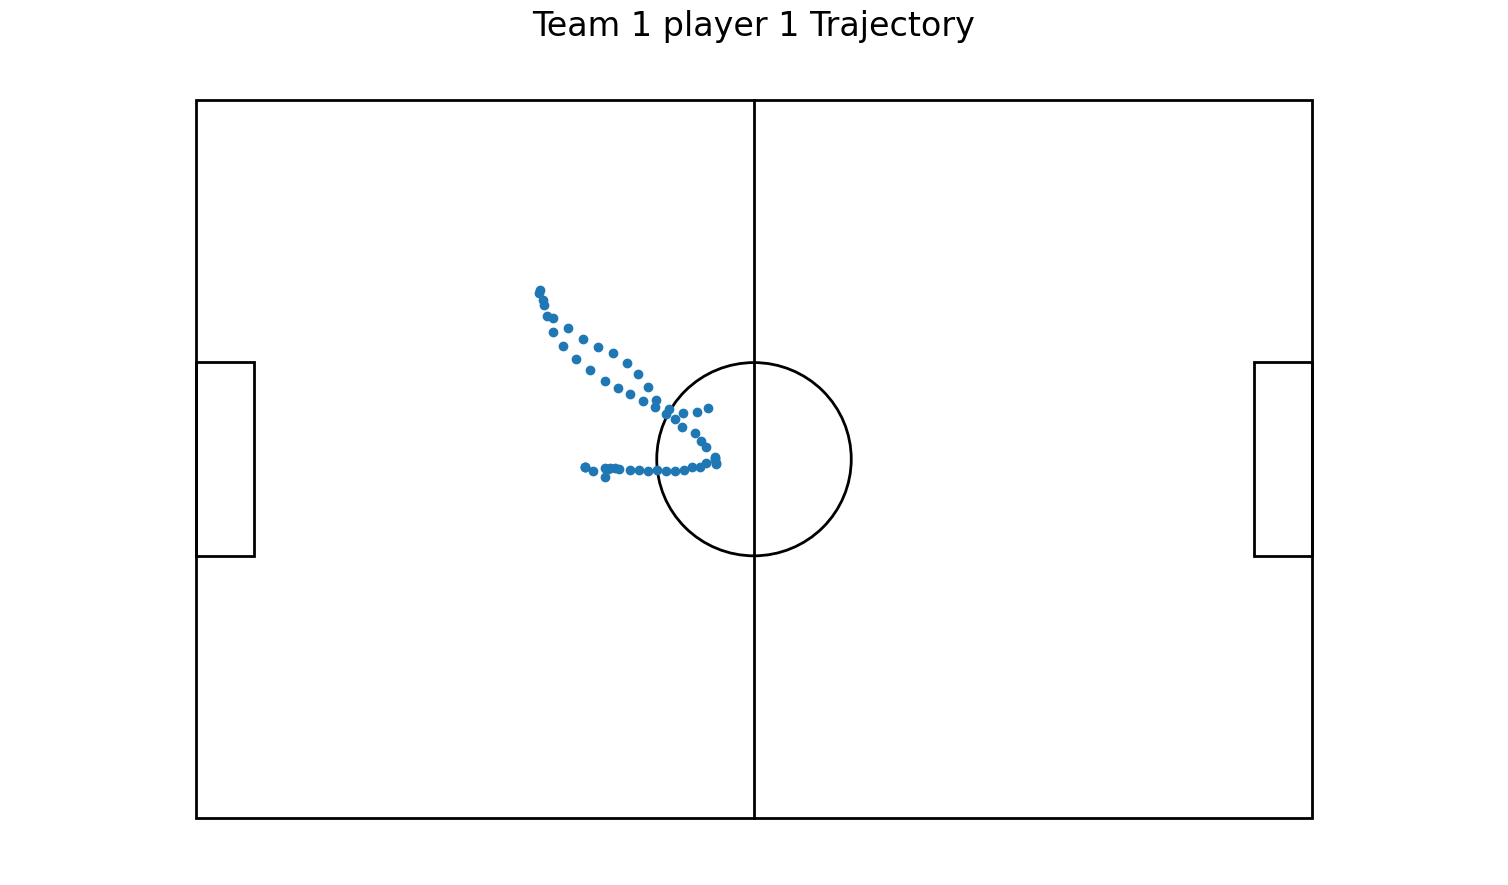

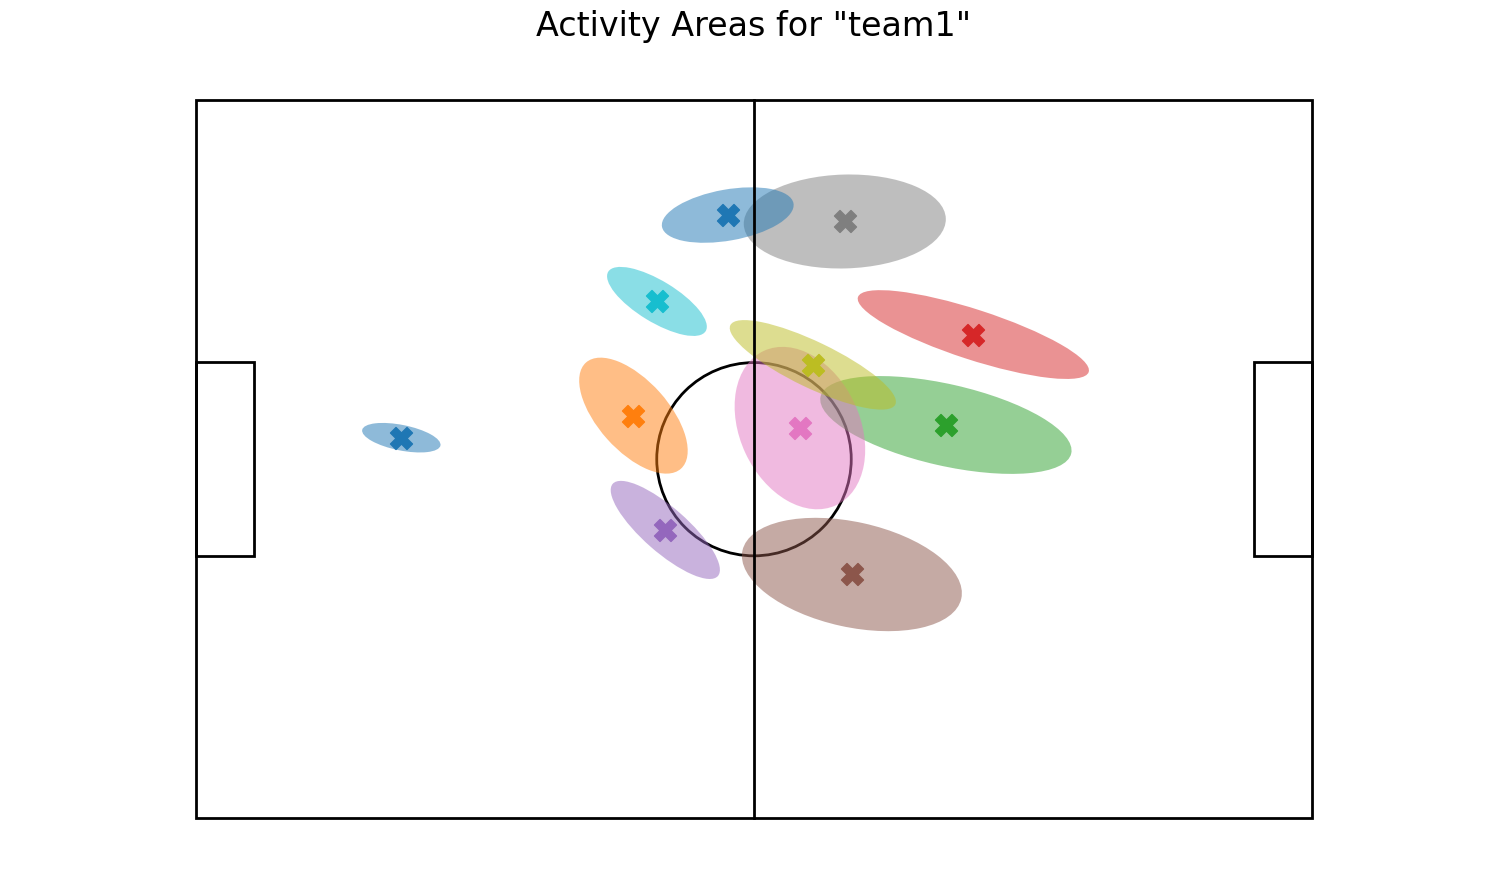

In [46]:
fig, ax = plt.subplots(figsize=(19.2, 10.8))
df = preprocess_df(dfs[0], normalize=False, n=15).reset_index(drop=True)
plot_player_posn(df, ax)
plt.xlim(0, 3840)
plt.ylim(0, 2160)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.title('Team 1 player 1 Trajectory', fontsize = 24)
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize=(19.2, 10.8))
plot_activity_areas(df, ax, activity_obj ="team1")
plt.xlim(0, 3840)
plt.ylim(0, 2160)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.title(f'Activity Areas for "team1"', fontsize = 24)
ax.axis('off')
plt.show()

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [248]:
from torch.utils.data import Dataset, DataLoader
class GameData(Dataset):
    def __init__(self, game_data):
        self.data = game_data # list of dataframes, each dataframe containing a game 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return preprocess_df(self.data[idx], normalize=True, n=15).reset_index(drop=True)    
    
    def get_columns(self):
        return self[0].columns
    
    def index(self, idx):
        """
        get unnormalized data 
        """
        return preprocess_df(self.data[idx], normalize=False, n=15).reset_index(drop=True)    


def collate_fn(batch):
    """
    Args:
        batch (list of DataFrame): The batch data, where each DataFrame in the list represents a sequence of player and ball positions.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, sequence_length, input_size) suitable for LSTM input.
    """
    # Initialize an empty list to store the processed sequences
    processed_sequences = []

    # Iterate over each sequence in the batch
    for sequence in batch:
        # Flatten each time step in the sequence and stack them into a single tensor
        sequence_tensor = torch.tensor(sequence.values.reshape(len(sequence), -1)).float()

        # Append the processed sequence to the list
        processed_sequences.append(sequence_tensor)

    # Pad the sequences so they all have the same length
    padded_sequences = torch.stack(processed_sequences).to(device)
    return padded_sequences


In [255]:
soccer_dataset = GameData(dfs[:45])
data_loader = DataLoader(soccer_dataset, batch_size=5, collate_fn=collate_fn)

In [51]:
def test_loader_and_dataset():
    print(soccer_dataset[0].columns)
    print(soccer_dataset[0]['player_0_x'])
    soccer_dataset[0].values[:, 0]

    for b in data_loader: 
        print(b )
        break

In [288]:
import torch
import torch.nn as nn

class LSTMWithLinear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMWithLinear, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        # Linear layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: input tensor of shape (batch_size, sequence_length, input_size)
        
        # Passing the input through the LSTM layer
        # lstm_out: tensor of shape (batch_size, sequence_length, hidden_size)
        lstm_out, _ = self.lstm(x)
        
        # Passing the output of the LSTM layer through the linear layer
        # This operation is applied to each time step, so we use lstm_out
        # linear_out: tensor of shape (batch_size, sequence_length, output_size)
        linear_out = self.linear(lstm_out)
        
        return linear_out

In [146]:
import random

In [289]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

try:
    del model 
except Exception as e:
    pass 

from transformers import get_linear_schedule_with_warmup
# Model, loss, and optimizer
N = len(data_loader)
num_epochs = 100 
num_training_steps = N * num_epochs
learning_rate = 1e-3
log_interval = 20

model = LSTMWithLinear(input_size=46, hidden_size=92, output_size=46, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=2,num_training_steps=num_training_steps)

# get_teacher_forcing_ratio = lambda epoch_num, batch_idx: 0.8 - (0.4 * epoch*(batch_idx + 1)/num_training_steps)


In [290]:
# Training loop
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(data_loader):
        optimizer.zero_grad()

        inputs = batch[:, :-1, :]  # All except the last time step
        targets = batch[:, 1:, :]  # All except the first time step

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
#         scheduler.step()

        if batch_idx % log_interval == 0:  # log_interval is a variable you can define to control logging frequency
            num_outs = outputs.shape[0] * outputs.shape[1] * outputs.shape[2]
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item()}')

    

    

Epoch [1/100], Step [1/9], Loss: 0.27432096004486084
Epoch [2/100], Step [1/9], Loss: 0.09219515323638916
Epoch [3/100], Step [1/9], Loss: 0.036140840500593185
Epoch [4/100], Step [1/9], Loss: 0.02738475427031517
Epoch [5/100], Step [1/9], Loss: 0.02611968107521534
Epoch [6/100], Step [1/9], Loss: 0.028395121917128563
Epoch [7/100], Step [1/9], Loss: 0.026589442044496536
Epoch [8/100], Step [1/9], Loss: 0.025073552504181862
Epoch [9/100], Step [1/9], Loss: 0.02400537207722664
Epoch [10/100], Step [1/9], Loss: 0.02343781664967537
Epoch [11/100], Step [1/9], Loss: 0.02179976925253868
Epoch [12/100], Step [1/9], Loss: 0.018831143155694008
Epoch [13/100], Step [1/9], Loss: 0.013461647555232048
Epoch [14/100], Step [1/9], Loss: 0.012469880282878876
Epoch [15/100], Step [1/9], Loss: 0.013267802074551582
Epoch [16/100], Step [1/9], Loss: 0.008886248804628849
Epoch [17/100], Step [1/9], Loss: 0.006846015807241201
Epoch [18/100], Step [1/9], Loss: 0.006263611372560263
Epoch [19/100], Step [1/9]

In [291]:
def denormalize_positions(test_dataset, norm_tensor, max_width=3840, max_height=2160):
    """
    norm_tensor(Torch.tensor[OutputLength, 46]): tensor with 46 positions for OutputLength frames. 
    Denormalize x and y positions from a [0, 1] range to their original scale.
    """
    
    output_names = test_dataset.get_columns()
    for idx in range(norm_tensor.shape[1]):
        if idx % 2 == 0: 
            norm_tensor[:,idx] *= max_width
        else: 
            norm_tensor[:,idx] *= max_height
    
    
    df = pd.DataFrame(norm_tensor.cpu().numpy(), columns=output_names)

    return df 
                               
def next_k_inference(test_dataset, num_available_frames, num_frames_to_predict):
    """
    input: test_dataset <torch dataset>. 
    output: list of dataframes, one for each element of the test dataset.
    """
    test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)
    
    predicted_dfs = [] 
    for batch_idx, batch in enumerate(test_loader):
        print(batch.shape)
        current_input = batch[:, :num_available_frames, :]  

        # Store all predictions here; initialize with the current input for simplicity
        predictions = current_input.clone()
        
        # Predict the next 'k' frames iteratively
        for _ in range(num_frames_to_predict):
            # Predict the next frame using the most recent frames
            with torch.no_grad():
                next_frame_pred = model(current_input)[:, -1:, :]  # Shape: [batch_size, 1, num_features]
            predictions = torch.cat((predictions, next_frame_pred), dim=1)
            current_input = torch.cat((current_input[:, 1:, :], next_frame_pred), dim=1)

        # Access the predicted frames 
        predicted_frames = predictions[:, num_available_frames:, :]
        print(predictions.shape)
        # convert the data into dataframe: 
        predicted_frames = predicted_frames.squeeze(0)
        predictions_as_df = denormalize_positions(test_dataset, predicted_frames)
        predicted_dfs.append(predictions_as_df)
    
    return predicted_dfs



In [292]:
def characteristic_area_by_frame(df, frame_number):
    # A demo of characteristic area
    # Specify the frame number to visualize

    # Plotting all player locations at a frame
    fig, ax = plt.subplots(figsize=(19.2, 10.8))
    _draw_soccer_field(ax)
    df_frame = df.iloc[1]
    reshaped_df = pd.DataFrame(df_frame.values.reshape(-1, 2), columns=['x', 'y'])

    # Team 1
    ax.scatter(reshaped_df.iloc[:11, 0], reshaped_df.iloc[:11, 1], color = colors[0], marker='o', s=500)
    plot_std_dev_ellipses(reshaped_df.iloc[:11], ax, color = colors[0])

    # Team 2
    ax.scatter(reshaped_df.iloc[11:22, 0], reshaped_df.iloc[11:22, 1], color = colors[1], marker='o', s=500)
    plot_std_dev_ellipses(reshaped_df.iloc[11:22], ax, color = colors[1])

    # Ball
    ax.scatter(reshaped_df.iloc[22, 0], reshaped_df.iloc[22, 1], color = 'black', marker='o', s=500)

    plt.xlim(0, 3840)
    plt.ylim(0, 2160)
    plt.gca().invert_yaxis()
    plt.title('Characteristic Area of both teams at the frame number of {frame_number}', fontsize = 24)
    ax.axis('off')
    plt.show()

In [293]:
from IPython.display import FileLink

model_path = 'model.pt'
torch.save(model, model_path)
download_link = FileLink(model_path, result_html_prefix="Click here to download your model: ")

# Display the download link
display(download_link)

/kaggle/working/model.pt

In [294]:
# Animate the changing characteristic area in a fast-forward video
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_game(actual, predicted=[]):
    # Define the function to update each frame in the animation
    
    def update(frame_number):
        ax.clear()
        
        if len(predicted) and frame_number >= len(actual): 
            is_future = True 
            df_frame = pred.iloc[frame_number - len(actual),:46] if is_future else actual.iloc[frame_number,:46]
        else: 
            is_future = False 
            df_frame =  actual.iloc[frame_number,:46]
        
        _draw_soccer_field(ax)
        reshaped_df = pd.DataFrame(df_frame.values.reshape(-1, 2), columns=['x', 'y'])

        # Team 1
        color = colors[0]
        ax.scatter(reshaped_df.iloc[:11, 0], reshaped_df.iloc[:11, 1], color=color, marker='o', s=100)
        plot_std_dev_ellipses(reshaped_df.iloc[:11], ax, color)

        # Team 2
        color = colors[1]
        ax.scatter(reshaped_df.iloc[11:22, 0], reshaped_df.iloc[11:22, 1], color=color, marker='o', s=100)
        plot_std_dev_ellipses(reshaped_df.iloc[11:22], ax, color)

        # Ball
        color = 'black'
        ax.scatter(reshaped_df.iloc[22, 0], reshaped_df.iloc[22, 1], color=color, marker='o', s=100)

        plt.gca().invert_yaxis()
        plt.title(f'Frame: {frame_number}, is Model Prediction:{is_future}')

    # Set up the figure
    fig, ax = plt.subplots(figsize=(9.6, 5.4))
    _draw_soccer_field(ax)
    plt.xlim(0, 3840)
    plt.ylim(0, 2160)
    ax.axis('off')

    fps = 2
    start_frame = 0

    # Calculate the number of frames for a 20-second video at the given fps
    num_frames_for_video = 5 * fps

    # Create animation
    ani = FuncAnimation(fig, update, frames=range(len(actual) + len(predicted)), interval=150)

    return ani 

torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])
torch.Size([1, 60, 46])
torch.Size([1, 75, 46])


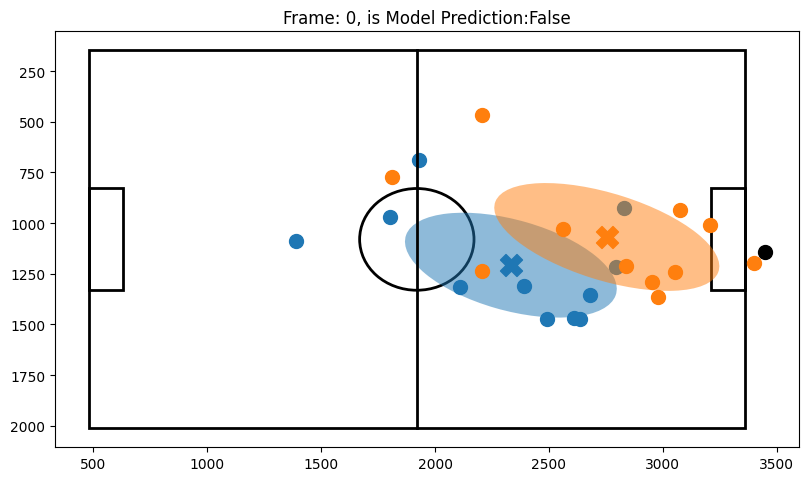

In [296]:
test_data = GameData(dfs[28:46])
predictions = next_k_inference(test_data, 30, 45)

actual = test_data.index(10).iloc[-30:]
pred = predictions[10]

ani = animate_game(actual, pred)
HTML(ani.to_html5_video())

In [302]:
test_data[1].to_csv('corner.csv')

,player_0_x,player_0_y,player_1_x,player_1_y,player_2_x,player_2_y,player_3_x,player_3_y,player_4_x,player_4_y,...,player_18_x,player_18_y,player_19_x,player_19_y,player_20_x,player_20_y,player_21_x,player_21_y,ball_x,ball_y
0,0.245312,0.511111,0.269792,0.715741,0.514844,0.498148,0.461198,0.666667,0.376302,0.856944,...,0.407552,0.263889,0.326823,0.569907,0.415104,0.731944,0.519271,0.567593,0.252344,0.517130
1,0.246875,0.512963,0.273438,0.714120,0.516797,0.498843,0.464583,0.671065,0.381510,0.870370,...,0.411458,0.267593,0.330469,0.574074,0.417318,0.738889,0.519010,0.571759,0.254539,0.528836
2,0.249609,0.521065,0.277083,0.712500,0.517969,0.502546,0.468099,0.675694,0.390885,0.885648,...,0.415365,0.273148,0.332031,0.583565,0.420182,0.746759,0.519141,0.585648,0.256641,0.540046
3,0.251563,0.531713,0.278516,0.713426,0.518880,0.507639,0.471484,0.680093,0.403255,0.903241,...,0.419271,0.281944,0.332682,0.592593,0.425781,0.754398,0.519010,0.600463,0.258478,0.550463
4,0.253255,0.546759,0.278906,0.715000,0.519271,0.515509,0.475130,0.684722,0.415885,0.915046,...,0.421745,0.290278,0.333594,0.598611,0.434896,0.759954,0.518750,0.616667,0.259967,0.560816
5,0.255990,0.563657,0.279167,0.716481,0.519271,0.524306,0.478646,0.689352,0.429297,0.922917,...,0.422135,0.297222,0.336458,0.603935,0.444010,0.764352,0.517839,0.627546,0.261111,0.570216
6,0.255990,0.576389,0.278646,0.716667,0.519271,0.533565,0.482422,0.693981,0.432292,0.918519,...,0.421224,0.303472,0.339583,0.608333,0.452604,0.764815,0.516406,0.635185,0.270168,0.634516
7,0.251302,0.584491,0.277669,0.716204,0.519271,0.543750,0.486589,0.699769,0.425781,0.911574,...,0.416406,0.308333,0.333724,0.628935,0.454167,0.775000,0.514714,0.642130,0.277691,0.695422
8,0.238932,0.588426,0.276986,0.716319,0.518490,0.554630,0.477995,0.712037,0.412370,0.910648,...,0.413021,0.315741,0.323698,0.653935,0.449219,0.792130,0.514323,0.650694,0.281076,0.703241
9,0.229687,0.586111,0.277865,0.705324,0.516667,0.564583,0.464323,0.723380,0.397656,0.911574,...,0.412891,0.326157,0.313672,0.671991,0.439583,0.808333,0.515234,0.657407,0.283333,0.698611


torch.Size([1, 60, 46])
torch.Size([1, 50, 46])
torch.Size([1, 60, 46])
torch.Size([1, 50, 46])


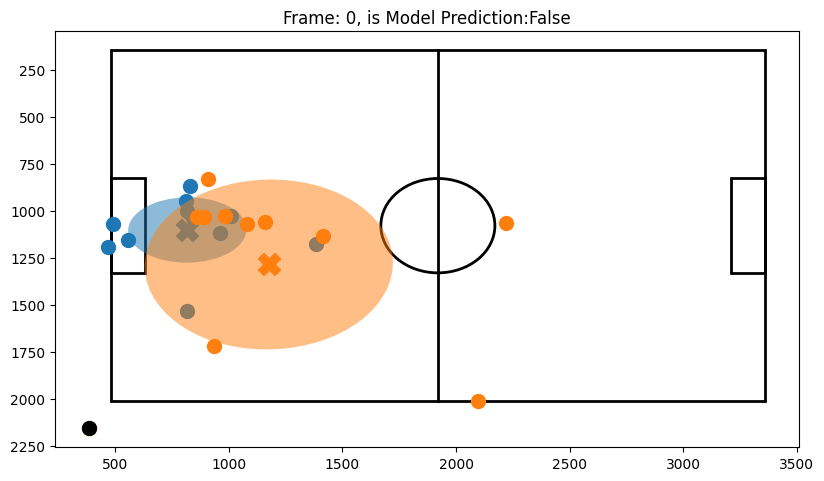

In [298]:
test_data = GameData(dfs[30:32])
predictions = next_k_inference(test_data, 30, 20)

actual = test_data.index(1).iloc[-20:]
pred = predictions[1]

ani = animate_game(actual, pred)
HTML(ani.to_html5_video())

In [247]:
actual

,player_0_x,player_0_y,player_1_x,player_1_y,player_2_x,player_2_y,player_3_x,player_3_y,player_4_x,player_4_y,...,player_18_x,player_18_y,player_19_x,player_19_y,player_20_x,player_20_y,player_21_x,player_21_y,ball_x,ball_y
880,458.00,1189.375,677.0,1286.5,1470.5,1088.0,1664.5,1365.0,582.0,1598.5,...,724.0,1347.0,753.10,1056.0,803.5,1500.0,1719.0,1388.0,412.263158,1691.368421
881,458.00,1189.250,677.5,1286.5,1467.0,1087.5,1661.5,1364.0,581.0,1596.5,...,725.0,1345.0,753.15,1056.0,803.0,1500.0,1717.0,1386.0,413.631579,1691.684211
882,458.00,1189.125,677.5,1285.5,1464.0,1087.5,1659.5,1364.0,580.0,1595.5,...,726.0,1342.0,753.20,1056.0,803.0,1499.0,1716.0,1385.0,415.000000,1692.000000
883,458.00,1189.000,678.5,1285.5,1461.0,1088.5,1656.0,1364.0,580.0,1593.5,...,727.0,1339.0,753.25,1056.0,802.0,1499.0,1714.0,1383.0,416.176471,1692.411765
884,458.25,1189.250,680.0,1286.0,1457.5,1088.5,1653.0,1363.0,579.0,1593.0,...,728.0,1336.0,753.30,1056.0,801.5,1498.5,1713.0,1382.0,417.352941,1692.823529
885,458.50,1189.500,681.0,1285.0,1454.5,1088.5,1651.0,1363.0,578.0,1591.0,...,729.0,1333.0,753.35,1056.0,801.0,1498.0,1712.5,1380.0,418.529412,1693.235294
886,458.75,1189.750,682.0,1285.0,1451.5,1089.5,1648.0,1363.0,578.0,1590.0,...,730.0,1331.0,753.40,1056.0,800.5,1498.0,1710.5,1379.0,419.705882,1693.647059
887,459.00,1190.000,684.0,1285.0,1448.5,1089.5,1645.0,1362.0,577.0,1588.0,...,731.0,1328.0,753.45,1056.0,800.0,1498.0,1709.5,1378.0,420.882353,1694.058824
888,459.00,1189.500,685.0,1284.0,1445.0,1089.5,1643.0,1362.0,576.0,1587.5,...,732.0,1325.0,753.50,1056.0,800.0,1497.0,1708.5,1376.0,422.058824,1694.470588
889,459.00,1189.375,686.0,1284.0,1442.0,1090.5,1639.5,1362.0,576.0,1585.5,...,733.0,1322.0,752.50,1056.0,799.0,1497.0,1706.5,1375.0,423.235294,1694.882353


In [ ]:

def ellipse_area(cov_matrix):
    eigenvalues, _ = np.linalg.eig(cov_matrix)
    # Semi-major and semi-minor axes (sqrt of eigenvalues)
    semi_major = np.sqrt(eigenvalues[0])
    semi_minor = np.sqrt(eigenvalues[1])
    # Area of ellipse
    area = np.pi * semi_major * semi_minor
    return area

areas_team1 = []
areas_team2 = []

for frame_number in range(len(df)):
    df_frame = df.iloc[frame_number]
    reshaped_df = pd.DataFrame(df_frame.values.reshape(-1, 2), columns=['x', 'y'])

    # Calculate area for Team 1
    area_team1 = ellipse_area(np.cov(reshaped_df.iloc[:11].T))
    areas_team1.append(area_team1)

    # Calculate area for Team 2
    area_team2 = ellipse_area(np.cov(reshaped_df.iloc[11:22].T))
    areas_team2.append(area_team2)

# Convert areas to DataFrame and rename columns
areas_team1_df = pd.DataFrame(areas_team1, columns=['area_team1'])
areas_team2_df = pd.DataFrame(areas_team2, columns=['area_team2'])

df['center_team1_x'] = df.iloc[:,0:22:2].mean(axis=1)
df['center_team1_y'] = df.iloc[:,1:22:2].mean(axis=1)
df['center_team2_x'] = df.iloc[:,22:-2:2].mean(axis=1)
df['center_team2_y'] = df.iloc[:,23:-2:2].mean(axis=1)

# Reset index ensures smooth concatenation
df = df.reset_index(drop=True)
areas_team1_df = areas_team1_df.reset_index(drop=True)
areas_team2_df = areas_team2_df.reset_index(drop=True)

# Concatenate area data into the original dataframe
df = pd.concat([df, areas_team1_df, areas_team2_df], axis=1)

# As a bonus, calculate distances between team1, team2, and the ball, adding them as new columns
df['team1_team2'] = np.sqrt((df['center_team1_x'] - df['center_team2_x'])**2 + (df['center_team1_y'] - df['center_team2_y'])**2)
df['team1_ball'] = np.sqrt((df['center_team1_x'] - df['ball_x'])**2 + (df['center_team1_y'] - df['ball_y'])**2)
df['team2_ball'] = np.sqrt((df['center_team2_x'] - df['ball_x'])**2 + (df['center_team2_y'] - df['ball_y'])**2)


# Plotting the time series and associated diagnostics for Team 1
import statsmodels.api
import statsmodels as sm
import seaborn as sns

def tsplot2(y, title, lags=None, figsize=(12, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.'''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot (ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold' )
    y.plot (ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.graphics.tsaplots.plot_acf (y, lags=lags, ax=acf_ax)
    sm.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

tsplot2(df_second.area_team1, "Team 1's characteristic area");

tsplot2(df_second.area_team2, "Team 2's characteristic area");


diff = df.diff().iloc[1:,:46]

# Initialize DataFrames to store velocities and directions
df_velocity = pd.DataFrame(index=diff.index)
df_direction = pd.DataFrame(index=diff.index)

# Calculate the velocity and direction for each player
for i in range(22):
    dx = diff[f'player_{i}_x']
    dy = diff[f'player_{i}_y']
    
    # Velocity magnitude
    df_velocity[f'player_{i}_velocity'] = np.sqrt(dx**2 + dy**2)
    
    # Velocity direction in radians
    df_direction[f'player_{i}_direction'] = np.arctan2(dy, dx)

In [ ]:
def are_synchronized(angle1, angle2, tolerance=0.2 * np.pi):
    """Check if two angles are within a certain tolerance."""
    # Normalize angles to [0, 2π] range
    angle1 = angle1 % (2 * np.pi)
    angle2 = angle2 % (2 * np.pi)

    # Calculate the absolute difference between angles
    diff = np.abs(angle1 - angle2)

    # Check if angles are within tolerance
    return diff <= tolerance or diff >= 2 * np.pi - tolerance

# Global variables to track synchronization over time
sync_tracker = {}  # Dictionary to track synchronization state

def update_sync_tracker(team, player_i, player_j, is_sync):
    """Update the synchronization tracker with the current state."""
    key = (team, min(player_i, player_j), max(player_i, player_j))
    sync_state = sync_tracker.get(key, {'count': 0, 'sync': False})

    if is_sync:
        sync_state['count'] += 1  # Increment sync count if players are synchronized
    else:
        sync_state['count'] -= 1  # Decrement sync count if players are not synchronized

    sync_state['count'] = max(0, min(sync_state['count'], 60))  # Keep count within [0, fps]
    sync_state['sync'] = sync_state['count'] >= 60  # Update sync status

    sync_tracker[key] = sync_state
    return sync_state['sync']

def update(frame_number):
    ax.clear()
    _draw_soccer_field(ax)

    # Get data for the current frame
    df_frame = df.iloc[frame_number, :46]
    reshaped_df = pd.DataFrame(df_frame.values.reshape(-1, 2), columns=['x', 'y'])
    df_direction_frame = df_direction.iloc[frame_number]

    # Plot players and draw lines for synchronized players
    for team in range(2):
        start_idx = team * 11
        end_idx = (team + 1) * 11
        color = colors[0] if team == 0 else colors[1]

        # Draw players
        ax.scatter(reshaped_df.iloc[start_idx:end_idx, 0], reshaped_df.iloc[start_idx:end_idx, 1], color=color, marker='o', s=100)

        # Check and draw lines for synchronized players
        for i in range(start_idx, end_idx):
            for j in range(i+1, end_idx):
                is_sync = are_synchronized(df_direction_frame[f'player_{i}_direction'], df_direction_frame[f'player_{j}_direction'])
                if update_sync_tracker(team, i, j, is_sync):
                    ax.plot([reshaped_df.iloc[i, 0], reshaped_df.iloc[j, 0]], 
                            [reshaped_df.iloc[i, 1], reshaped_df.iloc[j, 1]], 
                            color=color, linewidth=1)

    # Plot the ball
    ax.scatter(reshaped_df.iloc[22, 0], reshaped_df.iloc[22, 1], color='black', marker='o', s=100)

    plt.gca().invert_yaxis()
    plt.title(f'Frame: {frame_number}', fontsize = 24)

# Set up the figure
fig, ax = plt.subplots(figsize=(9.6, 5.4))
draw_soccer_field(ax)
plt.xlim(0, 3840)
plt.ylim(0, 2160)
ax.axis('off')

# Frame rate
fps = 150

# Start frame
start_frame = 12000

# Calculate the number of frames for a 20-second video at the given fps
num_frames_for_video = 20 * fps

# Select a subset of rows for the video
subset_df = df.iloc[start_frame:start_frame + num_frames_for_video]

# Create animation
ani = FuncAnimation(fig, update, frames=range(start_frame, start_frame + len(subset_df)), interval=1000/fps)

# Display the animation in the notebook
HTML(ani.to_html5_video())